## Import the required packages

In [0]:
!pip install open3d
!pip install glfw
!pip install matplotlib-scalebar
from skimage import io as skio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import open3d as o3d
from google.colab import drive
import scipy.signal as signal
import glfw as glfw


## Functions

### Depth-to-cloud

In [0]:
def depthToCloud(RGB, depth, topleft):
  if (topleft < 2):
    topleft = np.array([1,1])

  # Convert RGB to double and set 0 to nan
  RGB = RGB.astype(np.double)
  RGB[RGB==0] = np.nan

  # Convert depth to double and set 0 to nan
  depth = depth.astype(np.double)
  depth[depth==0] = np.nan

  # RGB-D camera constants
  [height, width, _] = RGB.shape
  center = np.array([height / 2, width / 2])
  matrix = np.true_divide(depth, depth)

  # Convert depth image to 3d point clouds
  pcloud = np.zeros((height, width, 3))
  xgrid = np.arange(1, height + 1)[:, None] * np.ones((1, width)) + (topleft.item(0) - 1) - center.item(0)
  ygrid = np.ones((height, 1)) * np.arange(1, width + 1) + (topleft.item(1) - 1) - center.item(1)
  pcloud[:, :, 0] = np.true_divide(np.multiply(xgrid, matrix), 100)
  pcloud[:, :, 1] = np.true_divide(np.multiply(ygrid, matrix), 100)
  pcloud[:, :, 2] = np.flipud(np.true_divide(depth[:, :], 1000))
  distance = np.sqrt(np.sum(np.power(pcloud, 2), 2))

  return [pcloud, distance]

### Data-to-cloud

In [0]:
def dataToCloud(RGB, MS, topleft):
  if (topleft < 2):
    topleft = np.array([1,1])

  # Convert RGB to double and set 0 to nan
  RGB = RGB.astype(np.double)
  RGB[RGB==0] = np.nan

  # Convert the multi data to double and set 0 to nan
  MS = MS.astype(np.double)
  MS[MS==0] = np.nan;

  # RGB-D camera constants
  [height, width, _] = RGB.shape
  center = np.array([height / 2, width / 2])
  matrix = np.true_divide(RGB[:,:,1], RGB[:,:,1])
  
  # Convert depth image to 3d point clouds
  pcloud = np.zeros((height, width, 3))
  xgrid = np.ones((height, 1)) * np.arange(1, width + 1) + (topleft.item(0) - 1) - center.item(0)
  ygrid = np.arange(1, height + 1)[:, None] * np.ones((1, width)) + (topleft.item(1) - 1) - center.item(1)
  pcloud[:, :, 0] = np.true_divide(np.multiply(xgrid, matrix), 100)
  pcloud[:, :, 1] = np.true_divide(np.multiply(ygrid, matrix), 100)
  pcloud[:, :, 2] = np.true_divide(MS[:, :], 1000)

  return pcloud

### PointCloud conversion

In [0]:
def reshape(matrix):
  x = matrix[:,:,0]
  y = matrix[:,:,1]
  z = matrix[:,:,2] # np.multiply(matrix[:,:,2], 1000)
  xyz = np.zeros((np.size(x), 3))
  xyz[:, 0] = x.reshape(-1, order='F').copy()
  xyz[:, 1] = y.reshape(-1, order='F').copy()
  xyz[:, 2] = z.reshape(-1, order='F').copy()

  return xyz

def toPointCloud(pcloud, RGB):
  xyz = reshape(pcloud)
  xyzRGB = reshape(RGB)
  ptCloud = o3d.geometry.PointCloud()
  ptCloud.points = o3d.utility.Vector3dVector(xyz)
  ptCloud.colors = o3d.utility.Vector3dVector(xyzRGB)

  return ptCloud

## Step 1: Generate and display the point cloud from the RGB-D images

### Read and display the RGB-D images

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


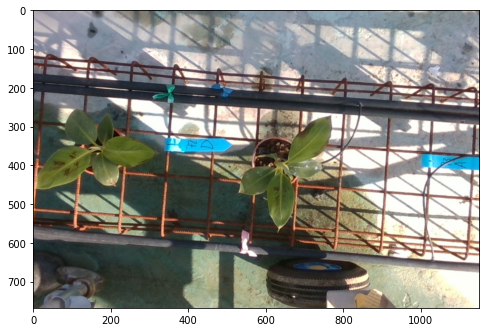

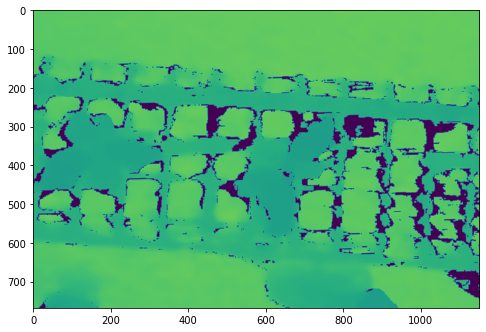

In [0]:
drive.mount('/content/gdrive')

# Use the skimage package to read 16-bit images correctly (as in matlab)
depth = skio.imread('/content/gdrive/My Drive/Processed/3D_Channel_RealSense_Depth.png')
RGB = skio.imread('/content/gdrive/My Drive/Processed/3D_Channel_RealSense_RGB.jpeg')

plt.figure(figsize=(8,8))
plt.imshow(RGB)

plt.figure(figsize=(8,8))
#Add Scale bar 
plt.imshow(depth)

### Convert depth to cloud points

In [0]:
[pcloud, distance] = depthToCloud(RGB, depth, 0)
z = pcloud[:,:,2]
print('Point cloud data')
print(pcloud.shape)
print('Z Point cloud data size')
print(z.size)
print('Color data')
print(RGB.shape)
print('Rgb Sum')
print(RGB.sum())
#RGB

Point cloud data
(768, 1152, 3)
Z Point cloud data size
884736
Color data
(768, 1152, 3)
Rgb Sum
328238082


### Convert the data to PointCloud using open3d and remove invalid points

In [0]:
ptCloud = toPointCloud(pcloud, RGB)
validPtCloud = o3d.geometry.PointCloud(ptCloud).remove_none_finite_points()
messyValidRGB = np.asarray(validPtCloud.colors)

print('Point cloud points')
print(pcloud.shape)

print('Point cloud valid points')
print(np.asarray(validPtCloud.points).shape)

print('Point cloud valid colors (messed order)')
print(messyValidRGB.shape)
print(messyValidRGB.sum())
messyValidRGB

Point cloud points
(768, 1152, 3)
Point cloud valid points
(789332, 3)
Point cloud valid colors (messed order)
(789332, 3)
285969484.0


array([[157., 157., 169.],
       [161., 161., 173.],
       [168., 166., 177.],
       ...,
       [254., 255., 249.],
       [254., 255., 247.],
       [254., 255., 247.]])

### Calculate the projection image

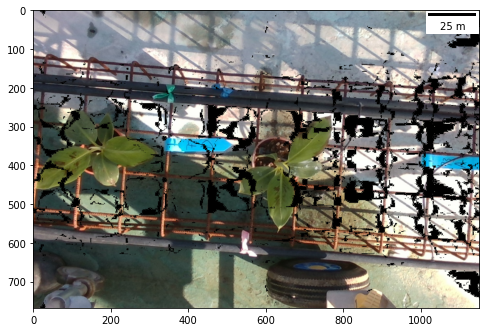

In [0]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib_scalebar.scalebar import ScaleBar

#glfw.AUTO_ICONIFY
ptCloudPoints = np.asarray(ptCloud.points)
validIndices = np.argwhere(np.isfinite(ptCloudPoints[:,0]) & np.isfinite(ptCloudPoints[:,1]) & np.isfinite(ptCloudPoints[:,2]))
count = np.asarray(ptCloud.points).shape[0]
indices = np.arange(0, count)
[u, v] = np.unravel_index(indices, (pcloud.shape[0], pcloud.shape[1]), order = 'F')
imagePoints = np.column_stack((u[validIndices],v[validIndices]))

projImage = np.zeros((np.max(imagePoints[:,0]) + 1, np.max(imagePoints[:,1]) + 1, 3))

for i in range(imagePoints.shape[0]):
  projImage[imagePoints[i, 0], imagePoints[i, 1], :] = messyValidRGB[i, :]
projImage = projImage.astype(np.uint8)

# The following line should display the point cloud. However, it does not work. Please, see: https://github.com/adioshun/gitBook_PCL/issues/1
#o3d.visualization.draw_geometries([ptCloud])
scalebar = ScaleBar(0.2)
plt.figure(figsize=(8,8))
plt.gca().add_artist(scalebar)
plt.imshow(projImage)

## Step 2

### Load a Multi data (MS and Thermal) captured by AgriEye sensor into the workspace

In [0]:
MS480 = skio.imread('/content/gdrive/My Drive/Processed/Multi_Channel_Robin_480.png');
MS520 = skio.imread('/content/gdrive/My Drive/Processed/Multi_Channel_Robin_520.png');
MS550 = skio.imread('/content/gdrive/My Drive/Processed/Multi_Channel_Robin_550.png');
MS670 = skio.imread('/content/gdrive/My Drive/Processed/Multi_Channel_Robin_670.png');
MS700 = skio.imread('/content/gdrive/My Drive/Processed/Multi_Channel_Robin_700.png');
MS730 = skio.imread('/content/gdrive/My Drive/Processed/Multi_Channel_Robin_730.png');
MS780 = skio.imread('/content/gdrive/My Drive/Processed/Multi_Channel_Robin_780.png');
thermal = skio.imread('/content/gdrive/My Drive/Processed/Thermal_Channel_0.png');

### DN2RAD

In [0]:
# Ratio calculated from old Banana MS image and new banana MS image for each Band
# In order to bring the corent RAW data to RADIANCE
# Coefficients to Banana in Rahan
DN2RAD = [0.059057,0.192245,0.594233,1.198960,1.871885,2.034510,2.075143]; 
 
MS480 = np.multiply(MS480, DN2RAD[0])
MS520 = np.multiply(MS520, DN2RAD[1])
MS550 = np.multiply(MS550, DN2RAD[2])
MS670 = np.multiply(MS670, DN2RAD[3])
MS700 = np.multiply(MS700, DN2RAD[4])
MS730 = np.multiply(MS730, DN2RAD[5])
MS780 = np.multiply(MS780, DN2RAD[6])
 
# Convert Multi Data image into 3D point cloud
# With dataToCloud_AgriEye function
# Saving the Multi data value
 
pcloudMS480 = dataToCloud(RGB, MS480, 0);
MS480rad = pcloudMS480[:, :, 2];
 
pcloudMS520 = dataToCloud(RGB, MS520, 0);
MS520rad = pcloudMS520[:, :, 2];
 
pcloudMS550 = dataToCloud(RGB, MS550, 0);
MS550rad = pcloudMS550[:, :, 2];
 
pcloudMS670 = dataToCloud(RGB, MS670, 0);
MS670rad = pcloudMS670[:, :, 2];
 
pcloudMS700 = dataToCloud(RGB, MS700, 0);
MS700rad = pcloudMS700[:, :, 2];
 
pcloudMS730 = dataToCloud(RGB, MS730, 0);
MS730rad = pcloudMS730[:, :, 2];
 
pcloudMS780 = dataToCloud(RGB, MS780, 0);
MS780rad = pcloudMS780[:, :, 2];

### Display multi spectral data

In [0]:
from skimage import exposure

# Create RGB image base on the RGB chanels of multi-spectral sensor
# Convert the channels to uint8 format just for display
# and enhance the colors with the rescale_intensity function
def enhance(MS670rad, MS550rad, MS480rad):
  cat = np.concatenate((MS670rad, MS550rad, MS480rad), axis=1) #AXIS CHANGED FROM 2 TO 1
  img = cat.astype(np.uint8)
  # Contrast stretching
  p2, p98 = np.percentile(img, (2, 98))

  return exposure.rescale_intensity(img, in_range=(p2, p98))


In [0]:
# %  with known location (471,630)
# % display example of Radiance in the image
# figure, plot([480 520 550 670 700 730 780],[MS480rad(471,630), MS520rad(471,630),MS550rad(471,630),MS670rad(471,630),MS700rad(471,630),MS730rad(471,630),MS780rad(471,630)])
# xlabel ('Wavelangth [nm]')
# ylabel (' Radiance [w/m^2-sr-um]')
# title('Example of leaf Radiance from MultiSpectral sensor')
 
# Enhance the colors
print(MS670rad.shape)
#print(MS670rad.sum(axis=1))
points = enhance(MS670rad,MS550rad,MS480rad);
print(points.shape)

(768, 1152)
(768, 3456)


## Export the data to a mat file for comparison in Matlab

In [0]:
from scipy import io

py_data = {
            'py_pcloud': pcloud,
            'py_distance': distance,
            'py_depth': depth,
            'py_rgb': RGB,
            'py_validPtCloud': np.asarray(validPtCloud.points),
            'py_validPtCloud_color': np.asarray(validPtCloud.colors),
            'py_projImage': projImage
            }

# The colors have a slight difference of 14 values between the matlab and the python version for certain points due to imread differences.
io.savemat('/content/gdrive/My Drive/Processed/py_data2.mat', py_data)

#BRDF *Correction*

# Median Filter apply example

In [0]:
def apply_median_filter(self, window_size=3):
    if self.mean_signal is None:
        self.x = signal.medfilt(self.x, window_size)
        self.y = signal.medfilt(self.y, window_size)
        self.z = signal.medfilt(self.z, window_size)
    else:
        self.mean_signal = signal.medfilt(self.mean_signal, window_size)


#Median Filter

>  [Median Filter examples](https://programtalk.com/python-examples-amp/scipy.signal.medfilt/)
>.  [Deep-Spying](https://programtalk.com/vs2/python/13208/Deep-Spying/server/analytics/modules/sensor/Sensor.py/)


In [0]:
def median_filter(self, point_function, kernel_size=3):
        all_ts = self.all_as_timeseries()
        filtered = signal.medfilt(point_function(all_ts),
                                  kernel_size=kernel_size)
        for qr, fv in zip(all_ts, filtered):
            qr.median = fv
        return all_ts

# Depression Angle Function


In [0]:
from math import *
import numpy as np

def asind(x):
    rad = np.arcsin(x)
    return np.degrees(rad)

def depAng(H, R, Re = 8.4774e+06):
  H2 = np.multiply(2, H)
  H2Re = np.multiply(H2, Re)
  R2 = np.multiply(2, R)

  return  asind(np.true_divide((H**2 + H*2*Re + R**2),(R2*(H + Re))))

In [0]:

import math
from numpy import nan

depth = skio.imread('/content/gdrive/My Drive/Processed/3D_Channel_RealSense_Depth.png')
RGB = skio.imread('/content/gdrive/My Drive/Processed/3D_Channel_RealSense_RGB.jpeg')


MS480_DN = skio.imread('/content/gdrive/My Drive/Processed/Multi_Channel_Robin_480.png');
MS520_DN = skio.imread('/content/gdrive/My Drive/Processed/Multi_Channel_Robin_520.png');
MS550_DN = skio.imread('/content/gdrive/My Drive/Processed/Multi_Channel_Robin_550.png');
MS670_DN = skio.imread('/content/gdrive/My Drive/Processed/Multi_Channel_Robin_670.png');
MS700_DN = skio.imread('/content/gdrive/My Drive/Processed/Multi_Channel_Robin_700.png');
MS730_DN = skio.imread('/content/gdrive/My Drive/Processed/Multi_Channel_Robin_730.png');
MS780_DN = skio.imread('/content/gdrive/My Drive/Processed/Multi_Channel_Robin_780.png');
thermal = skio.imread('/content/gdrive/My Drive/Processed/Thermal_Channel_0.png');

DN2RAD = np.asarray([0.059057, 0.192245, 0.594233, 1.198960, 1.871885, 2.034510, 2.075143])
 
MS480 = np.multiply(MS480_DN, DN2RAD[0])
MS520 = np.multiply(MS520_DN, DN2RAD[1])
MS550 = np.multiply(MS550_DN, DN2RAD[2])
MS670 = np.multiply(MS670_DN, DN2RAD[3])
MS700 = np.multiply(MS700_DN, DN2RAD[4])
MS730 = np.multiply(MS730_DN, DN2RAD[5])
MS780 = np.multiply(MS780_DN, DN2RAD[6])
 
# Convert Multi Data image into 3D point cloud
# With dataToCloud_AgriEye function
# Saving the Multi data value
 
pcloudMS480 = dataToCloud(RGB, MS480, 0);
MS480rad = pcloudMS480[:, :, 2];


pcloudMS520 = dataToCloud(RGB, MS520, 0);
MS520rad = pcloudMS520[:, :, 2];
 
pcloudMS550 = dataToCloud(RGB, MS550, 0);
MS550rad = pcloudMS550[:, :, 2];
 
pcloudMS670 = dataToCloud(RGB, MS670, 0);
MS670rad = pcloudMS670[:, :, 2];
 
pcloudMS700 = dataToCloud(RGB, MS700, 0);
MS700rad = pcloudMS700[:, :, 2];
 
pcloudMS730 = dataToCloud(RGB, MS730, 0);
MS730rad = pcloudMS730[:, :, 2];
 
pcloudMS780 = dataToCloud(RGB, MS780, 0);
MS780rad = pcloudMS780[:, :, 2];
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%%%%%%% BRDF Correction %%%%%%% 
#% extract row and column size from z   
#filter2 = signal.medfilt(z)
#% smoth the outliners in z by using medfilter function of matlab 
#% were each output pixel contains the median value in the 3 - by - 3
#% neighborhood  arround the croosponding pixel in the input image (z)
#% Filter2 = signal.medfilt(z)
#% Change all values that are les than 1
#% from the Filted image
#% the sensor is 1m above the object
[pcloud, distance] = depthToCloud(RGB, depth, 0)
z = pcloud[:,:,2]
[r, c] = np.shape(z)
Filter2 = signal.medfilt(z)
dang = np.zeros(np.shape(z))

for i in range(r):
  for j in range(c):
    if Filter2[i, j] >= 1:
        Filter2[i, j] = Filter2[i,j]
    else:
        Filter2[i, j] = nan
        
#Filter2 array upside down flip flup it
Filter2 = np.flipud(Filter2)

#The minimal distance between the sansor to object
#H_min = np.double(np.min(np.min(Filter2))) 
## TO-DO extract min vlue from Filter2
H_min = 1
# Calculate the depth Coefficient
H =  np.true_divide(Filter2, H_min)
#Implaement the depth coefficient om MultiSpectral Data from 
Rad2d_depth480 = np.multiply(MS480rad, H)
Rad2d_depth520 = np.multiply(MS520rad, H)
Rad2d_depth550 = np.multiply(MS550rad, H)
Rad2d_depth670 = np.multiply(MS670rad, H)
Rad2d_depth700 = np.multiply(MS700rad, H)
Rad2d_depth730 = np.multiply(MS730rad, H)
Rad2d_depth780 = np.multiply(MS780rad, H)

for i in range(r):
  for j in range(c):
    if math.isnan(Filter2[i, j]):
      dang[i, j] = 0
    else:
      dang[i, j] = depAng(1, Filter2[i, j])


# Generating new metrix
# in size of the origenal image (z) 
# and the starting value is 90 to all cells
coef = np.ones((r,c))
coef = coef*90
angcoef = np.ones((r,c))


for i in range(r):
  for j in range(c):
    if dang[i, j] < 60:
       angcoef[i, j] = nan
    else:
       angcoef[i, j] = np.true_divide(coef[i, j], dang[i, j])
# Calculat parameters to 3D correction in 2 steps%%%
# Coefficient based on polynom calculation from SPHER
# Alignment each of the pixels  - the small Align 
# Test 
Rad3dang_480 = np.multiply(-3.0929, np.power(angcoef, 2)) + np.multiply(4.4708, angcoef)-0.4843
Rad3dang_520 = np.multiply(1.9053, np.power(angcoef, 2)) - np.multiply(6.8177, angcoef)+5.8257
Rad3dang_550 = np.multiply(-1.4214, np.power(angcoef, 2)) + np.multiply(1.2813, angcoef)+0.8046
Rad3dang_670 = np.multiply(1.1746, np.power(angcoef, 2)) - np.multiply(3.6691, angcoef)+2.8396
Rad3dang_700 = np.multiply(1.4149, np.power(angcoef, 2)) - np.multiply(3.9761, angcoef)+2.8536
Rad3dang_730 = np.multiply(0.4538, np.power(angcoef, 2)) - np.multiply(1.6242, angcoef)+1.4194
Rad3dang_780 = np.subtract(np.multiply(-0.1729, np.power(angcoef, 2)), np.add(np.multiply(0.3105, angcoef), 0.7748))

#Seconde Align - to the sensor
Rad3dang_coef480 = 1.+1.-Rad3dang_480
Rad3dang_coef520 = 1.+1.-Rad3dang_520
Rad3dang_coef550 = 1.+1.-Rad3dang_550
Rad3dang_coef670 = 1.+1.-Rad3dang_670
Rad3dang_coef700 = 1.+1.-Rad3dang_700
Rad3dang_coef730 = 1.+1.-Rad3dang_730
Rad3dang_coef780 = 1.+1.-Rad3dang_780

#% 3D correction based on BRDF
#% project each pixel to one plane 

Rad3d_corr480 = np.multiply(Rad2d_depth480, Rad3dang_coef480)
Rad3d_corr520 = np.multiply(Rad2d_depth520, Rad3dang_coef520)
Rad3d_corr550 = np.multiply(Rad2d_depth550, Rad3dang_coef550)
Rad3d_corr670 = np.multiply(Rad2d_depth670, Rad3dang_coef670)
Rad3d_corr700 = np.multiply(Rad2d_depth700, Rad3dang_coef700)
Rad3d_corr730 = np.multiply(Rad2d_depth730, Rad3dang_coef730)
Rad3d_corr780 = np.multiply(Rad2d_depth780, Rad3dang_coef780)

# Second Align - to the sensor



# 3D correction based on BRDF project each pixel to one plane 

Rad3d_corr520 = np.multiply(Rad2d_depth520, Rad3dang_coef520)
Rad3d_corr550 = np.multiply(Rad2d_depth550, Rad3dang_coef550)
Rad3d_corr670 = np.multiply(Rad2d_depth670, Rad3dang_coef670)
Rad3d_corr700 = np.multiply(Rad2d_depth700, Rad3dang_coef700)
Rad3d_corr730 = np.multiply(Rad2d_depth730, Rad3dang_coef730)
Rad3d_corr780 = np.multiply(Rad2d_depth780, Rad3dang_coef780)

#Radiance2Reflectance 
#Gain coefficients calculated from lab experiment for each Band
#In order to bring the corent RADIANCE data to Reflectance
#Coefficients to Banana in Rahan
Gain = np.asarray([0.0428, 0.0301, 0.0179, 0.0056, 0.0089, 0.0083, 0.0074])

Ref3d_corr480 = np.multiply(Rad3d_corr480, Gain[0])
Ref3d_corr520 = np.multiply(Rad3d_corr520, Gain[1])
Ref3d_corr550 = np.multiply(Rad3d_corr550, Gain[2])
Ref3d_corr670 = np.multiply(Rad3d_corr670, Gain[3])
Ref3d_corr700 = np.multiply(Rad3d_corr700, Gain[4])
Ref3d_corr730 = np.multiply(Rad3d_corr730, Gain[5])
Ref3d_corr780 = np.multiply(Rad3d_corr780, Gain[6])
print(Ref3d_corr780[421,422])



#Create RGB image base on the RGB chanels of the Reflectance 3D correction data of MultySpectral sensor
#convert the chanels to uint8 format just for disply
#and Enhanse the colors with imadjust function



0.3132502052821719


In [0]:
from skimage import exposure

# Create RGB image base on the RGB chanels of multi-spectral sensor
# Convert the channels to uint8 format just for display
# and enhance the colors with the rescale_intensity function
def enhance2(MS670rad, MS550rad, MS480rad):
  cat = np.concatenate((MS670rad, MS550rad, MS480rad), axis=1) #AXIS CHANGED FROM 2 TO 1
  img = cat.astype(np.uint8)
  # Contrast stretching
  p2, p98 = np.percentile(img, (2, 98))

  return exposure.rescale_intensity(img, in_range=(p2, p98))

#Calculate depression Test **angle**

In [0]:
#% depAng = sin-1((H^2 + 2HRe + R^2)/(2R(H + Re)))
from math import *
import numpy as np

def asind(x):
    rad = np.arcsin(x)
    return np.degrees(rad)

def depAng(H, R, Re = 8.4774e+06):
  H2 = np.multiply(2, H)
  H2Re = np.multiply(H2, Re)
  R2 = np.multiply(2, R)

  return  asind(np.true_divide((H**2 + H*2*Re + R**2),(R2*(H + Re)))).astype(np.double)

print(depAng(300,1000))



17.460826708758372


In [0]:
import math


[pcloud, distance] = depthToCloud(RGB, depth, 0)
z = pcloud[:,:,2]
[r,c] = np.shape(z)
dang = np.zeros(np.shape(z))
Filter2 = signal.medfilt(z)
for i in range(r):
  for j in range(c):
    if math.isnan(Filter2[i, j]):
      dang[i, j] = 0
    else:
      dang[i, j] = depAng(1, Filter2[i, j])
      #dnag = dang.astype(np.double)
print(dang)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in arcsin
  """


[[        nan 46.79116082 46.8356686  ... 44.64730894 44.64730894
          nan]
 [46.65824496 46.65824496 46.79116082 ... 44.60757908 44.60757908
  44.64730894]
 [46.65824496 46.65824496 46.79116082 ... 44.60757908 44.60757908
  44.60757908]
 ...
 [44.4494852  44.4494852  44.37092935 ... 43.98296663 44.02140644
  44.0599247 ]
 [44.4494852  44.4494852  44.4101666  ... 43.944605   43.98296663
  44.0599247 ]
 [        nan 44.4494852  44.4494852  ... 43.944605   43.98296663
          nan]]


In [0]:
[pcloud, distance] = depthToCloud(RGB, depth, 0)
z = pcloud[:,:,2]
[r,c] = np.shape(z)
Filter2 = signal.medfilt(z)
dang = np.zeros(np.shape(z))

for i in range(r):
  for j in range(c):
    if Filter2[i,j] >= 1:
        Filter2[i,j] = Filter2[i,j]
    else:
      Filter2[i,j] = nan

for i in range(r):
  for j in range(c):
    if math.isnan(Filter2[i, j]):
      dang[i, j] = 0
    else:
      dang[i, j] = depAng(1, Filter2[i, j])
print(dang)

[[ 0.         46.79116082 46.8356686  ... 44.64730894 44.64730894
   0.        ]
 [46.65824496 46.65824496 46.79116082 ... 44.60757908 44.60757908
  44.64730894]
 [46.65824496 46.65824496 46.79116082 ... 44.60757908 44.60757908
  44.60757908]
 ...
 [44.4494852  44.4494852  44.37092935 ... 43.98296663 44.02140644
  44.0599247 ]
 [44.4494852  44.4494852  44.4101666  ... 43.944605   43.98296663
  44.0599247 ]
 [ 0.         44.4494852  44.4494852  ... 43.944605   43.98296663
   0.        ]]


#Test H_min from min Filter2

In [0]:
[pcloud, distance] = depthToCloud(RGB, depth, 0)
z = pcloud[:,:,2]
[r,c] = np.shape(z)
Filter2 = signal.medfilt(z)
dang = np.zeros(np.shape(z))

for i in range(r):
  for j in range(c):
    if Filter2[i,j] >= 1:
        Filter2[i,j] = Filter2[i,j]
    else:
      Filter2[i,j] = nan

H_min = np.double(np.min(np.min(Filter2))) 
for i in range(r):
  for j in range(c):
    if math.isnan(Filter2[i, j]):
      dang[i, j] = 0
    else:
      dang[i, j] = depAng(1, Filter2[i, j])
print(dang)

[[ 0.         46.79116082 46.8356686  ... 44.64730894 44.64730894
   0.        ]
 [46.65824496 46.65824496 46.79116082 ... 44.60757908 44.60757908
  44.64730894]
 [46.65824496 46.65824496 46.79116082 ... 44.60757908 44.60757908
  44.60757908]
 ...
 [44.4494852  44.4494852  44.37092935 ... 43.98296663 44.02140644
  44.0599247 ]
 [44.4494852  44.4494852  44.4101666  ... 43.944605   43.98296663
  44.0599247 ]
 [ 0.         44.4494852  44.4494852  ... 43.944605   43.98296663
   0.        ]]


In [0]:
def depthToCloud(RGB, depth, topleft):
  if (topleft < 2):
    topleft = np.array([1,1])

  # Convert RGB to double and set 0 to nan
  RGB = RGB.astype(np.double)
  RGB[RGB==0] = np.nan

  # Convert depth to double and set 0 to nan
  depth = depth.astype(np.double)
  depth[depth==0] = np.nan

  # RGB-D camera constants
  [height, width, _] = RGB.shape
  center = np.array([height / 2, width / 2])
  matrix = np.true_divide(depth, depth)

  # Convert depth image to 3d point clouds
  pcloud = np.zeros((height, width, 3))
  xgrid = np.arange(1, height + 1)[:, None] * np.ones((1, width)) + (topleft.item(0) - 1) - center.item(0)
  ygrid = np.ones((height, 1)) * np.arange(1, width + 1) + (topleft.item(1) - 1) - center.item(1)
  pcloud[:, :, 0] = np.true_divide(np.multiply(xgrid, matrix), 100)
  pcloud[:, :, 1] = np.true_divide(np.multiply(ygrid, matrix), 100)
  pcloud[:, :, 2] = np.flipud(np.true_divide(depth[:, :], 1000))
  distance = np.sqrt(np.sum(np.power(pcloud, 2), 2))

  return [pcloud, distance]

In [0]:
def depthToCloud(RGB, depth, topleft):
  if (topleft < 2):
    topleft = np.array([1,1])

  # Convert RGB to double and set 0 to nan
  RGB = RGB.astype(np.double)
  RGB[RGB==0] = np.nan

  # Convert depth to double and set 0 to nan
  depth = depth.astype(np.double)
  depth[depth==0] = np.nan

  # RGB-D camera constants
  [height, width, _] = RGB.shape
  center = np.array([height / 2, width / 2])
  matrix = np.true_divide(depth, depth)

  # Convert depth image to 3d point clouds
  pcloud = np.zeros((height, width, 3))
  xgrid = np.arange(1, height + 1)[:, None] * np.ones((1, width)) + (topleft.item(0) - 1) - center.item(0)
  ygrid = np.ones((height, 1)) * np.arange(1, width + 1) + (topleft.item(1) - 1) - center.item(1)
  pcloud[:, :, 0] = np.true_divide(np.multiply(xgrid, matrix), 100)
  pcloud[:, :, 1] = np.true_divide(np.multiply(ygrid, matrix), 100)
  pcloud[:, :, 2] = np.flipud(np.true_divide(depth[:, :], 1000))
  distance = np.sqrt(np.sum(np.power(pcloud, 2), 2))

  return [pcloud, distance]

In [0]:
[pcloud, distance] = depthToCloud(RGB, depth, 0)
z = pcloud[:,:,2]
[r,c] = np.shape(z)
Filter2 = signal.medfilt(z)

for i in range(r):
  for j in range(c):
    if Filter2[i,j] >= 1:
        Filter2[i,j] = Filter2[i,j]
    else:
      Filter2[i,j] = nan

In [0]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow as imshow

image = cv2.imread('/content/gdrive/My Drive/Processed/3D_Channel_RealSense_RGB.jpeg')
imshow(image)

blur = cv2.GaussianBlur(image, (5,55),0)
imshow(blur)

kernel = np.ones((5,5),'uint8')

dilate = cv2.dilate(image,kernel,iterations=1)
erode = cv2.erode(image,kernel,iterations=1)

imshow(dilate)
imshow(erode)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [0]:
#%%%%%% Calculate depression angle %%%%%
#% depAng = sin-1((H^2 + 2HRe + R^2)/(2R(H + Re)))
#% H = H_min;  minimum depth Coefficient - calculated in line 153
#% Re = Effective earth radius in meters. Default: approximately 4/3
#% times the actual earth radius - Scalar
#% R = Filter2; - calculated in line 145



for i in np.arange(1., (r)+1):
    for j in np.arange(1., (c)+1):
        if np.isnan(Filter2[int(i)-1,int(j)-1]) == 1.:
            depAng[int(i)-1,int(j)-1] = 0.
        else:
            depAng[int(i)-1,int(j)-1] = depressionang(H_min, Filter2[int(i)-1,int(j)-1], 'curved')
            
        
        
    
#% Generating new metrix
#% in size of the origenal image (z) 
#% and the starting value is 90 to all cells
coef = np.ones(r, c)
coef = coef*90.
#% Filter all values that are less the 60
#% our method dosent calculate from 60 degree and less
for i in np.arange(1., (r)+1):
    for j in np.arange(1., (c)+1):
        if depAng[int(i)-1,int(j)-1]<60.:
            angcoef[int(i)-1,int(j)-1] = NaN
        else:
            angcoef[int(i)-1,int(j)-1] = matdiv(coef[int(i)-1,int(j)-1], depAng[int(i)-1,int(j)-1])
 

TypeError: ignored

#Calculat parameters to 3D correction in 2 steps

In [0]:
#%%%% Calculat parameters to 3D correction in 2 steps%%%
#% Coefficient based on polynom calculation from SPHER
#% Alignment each of the pixels  - the small Align 
Rad3dang_480 = np.dot(-3.0929, angcoef**2.)+np.dot(4.4708, angcoef)-0.4843
Rad3dang_520 = np.dot(1.9053, angcoef**2.)-np.dot(6.8177, angcoef)+5.8257
Rad3dang_550 = np.dot(-1.4214, angcoef**2.)+np.dot(1.2813, angcoef)+0.8046
Rad3dang_670 = np.dot(1.1746, angcoef**2.)-np.dot(3.6691, angcoef)+2.8396
Rad3dang_700 = np.dot(1.4149, angcoef**2.)-np.dot(3.9761, angcoef)+2.8536
Rad3dang_730 = np.dot(0.4538, angcoef**2.)-np.dot(1.6242, angcoef)+1.4194
Rad3dang_780 = np.dot(-0.1729, angcoef**2.)-np.dot(0.3105, angcoef)+0.7748
#% Seconde Align - to the sensor
Rad3dang_coef480 = 1.+1.-Rad3dang_480
Rad3dang_coef520 = 1.+1.-Rad3dang_520
Rad3dang_coef550 = 1.+1.-Rad3dang_550
Rad3dang_coef670 = 1.+1.-Rad3dang_670
Rad3dang_coef700 = 1.+1.-Rad3dang_700
Rad3dang_coef730 = 1.+1.-Rad3dang_730
Rad3dang_coef780 = 1.+1.-Rad3dang_780
#% 3D correction based on BRDF
#% project each pixel to one plane 
Rad3d_corr480 = Rad2d_depth480*Rad3dang_coef480
Rad3d_corr520 = Rad2d_depth520*Rad3dang_coef520
Rad3d_corr550 = Rad2d_depth550*Rad3dang_coef550
Rad3d_corr670 = Rad2d_depth670*Rad3dang_coef670
Rad3d_corr700 = Rad2d_depth700*Rad3dang_coef700
Rad3d_corr730 = Rad2d_depth730*Rad3dang_coef730
Rad3d_corr780 = Rad2d_depth780*Rad3dang_coef780

#Radiance2Reflectance

In [0]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%%%%%%% Radiance2Reflectance %%%%%%% 
#% Gain coefficients calculated from lab experiment for each Band
#% In order to bring the corent RADIANCE data to Reflectance
#% Coefficients to Banana in Rahan
Gain = np.array(np.hstack((0.0428, 0.0301, 0.0179, 0.0056, 0.0089, 0.0083, 0.0074)))
Ref3d_corr480 = np.dot(Rad3d_corr480, Gain[0])
Ref3d_corr520 = np.dot(Rad3d_corr520, Gain[1])
Ref3d_corr550 = np.dot(Rad3d_corr550, Gain[2])
Ref3d_corr670 = np.dot(Rad3d_corr670, Gain[3])
Ref3d_corr700 = np.dot(Rad3d_corr700, Gain[4])
Ref3d_corr730 = np.dot(Rad3d_corr730, Gain[5])
Ref3d_corr780 = np.dot(Rad3d_corr780, Gain[6])

In [0]:

import numpy as np
import scipy
import matplotlib.pyplot as plt

# if available import pylab (from matlibplot)
try:
    import matplotlib.pylab as plt
except ImportError:
    pass

clc
#% Clear the command window.
plt.close(all)
#% Close all figures (except those of imtool.)
clear
#% Erase all existing variables. Or clearvars if you want.
workspace
#% Make sure the workspace panel is showing.
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%%%%%%% Generatingh Point Cloud from RGB-D Object Dataset (full image REGISTRET) from AgriEye:%%%%%%%% 
#% Load RGB-D data 3-D captured by AgriEye sensor into the workspace.
depth = plt.imread('Processed\3D_Channel_RealSense_Depth.png')
rgb = plt.imread('Processed\3D_Channel_RealSense_RGB.jpeg')
#% Display the RAW DATA 
plt.subplot(1., 2., 1.)
plt.imshow(rgb)
plt.title('RGB From RealSense Camera')
plt.subplot(1., 2., 2.)
imagesc(depth)
plt.colorbar
plt.title('Depth Data From RealSense Camera')
#% Convert depth image into 3D point cloud
#% With depthToCloud_AgriEye function
pcloud = depthToCloud_AgriEye(rgb, depth, 0.)
ptCloud = pointCloud(pcloud, 'Color', rgb)
x = pcloud[:,:,0]
y = pcloud[:,:,1]
z = pcloud[:,:,2]
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%%%%%%% Validetion for point cloud to 2D converting %%%%%%%  
#% Remove points with Inf or NaN coordinates from the point cloud.
[validPtCloud, validIndices] = removeInvalidPoints(ptCloud)
#% Read the valid point coordinates.
#% Each entry specifies the x, y, z coordinates of a point in the point cloud.
worldPoints = validPtCloud.Location
#% Define the corresponding image point coordinates as a orthographic projection
#% of point cloud data onto the yz-plane.
indices = np.arange(1., (ptCloud.Count)+1)
[u, v] = ind2sub(np.array(np.hstack((matcompat.size((ptCloud.Location), 1.), matcompat.size((ptCloud.Location), 2.)))), indices)
imagePoints = np.array(np.hstack((u[int(validIndices)-1].conj().T, v[int(validIndices)-1].conj().T)))
#% Generate the 2-D image projection by using 
#% the image point coordinates and their color values.
projImage = np.zeros(matcompat.max(imagePoints[:,0]), matcompat.max(imagePoints[:,1]), 3.)
rgb_test = validPtCloud.Color
for j in np.arange(1., (length(rgb_test))+1):
    projImage[int(imagePoints[int(j)-1,0])-1,int(imagePoints[int(j)-1,1])-1,:] = rgb_test[int(j)-1,:]
    
#% Display the point cloud data and the corresponding 2-D image projection.
plt.figure
plt.subplot(1., 2., 1.)
pcshow(ptCloud)
camorbit(140., 45.)
plt.title('Point Cloud Data', 'Color', np.array(np.hstack((1., 1., 1.))))
plt.xlabel('X')
plt.ylabel('Y')
zlabel('Z')
plt.subplot(1., 2., 2.)
plt.imshow(np.uint8(projImage))
plt.title('2-D Image Projection', 'Color', np.array(np.hstack((1., 1., 1.))))
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%%%%%%% Load a Multi data (MS and Thermal)  captured by AgriEye sensor into the workspace %%%%%%% 
MS480_DN = plt.imread('Processed\Multi_Channel_Robin_480.png')
MS520_DN = plt.imread('Processed\Multi_Channel_Robin_520.png')
MS550_DN = plt.imread('Processed\Multi_Channel_Robin_550.png')
MS670_DN = plt.imread('Processed\Multi_Channel_Robin_670.png')
MS700_DN = plt.imread('Processed\Multi_Channel_Robin_700.png')
MS730_DN = plt.imread('Processed\Multi_Channel_Robin_730.png')
MS780_DN = plt.imread('Processed\Multi_Channel_Robin_780.png')
Thermal = plt.imread('Processed\Thermal_Channel_0.png')
#%Disply MultiSpectral data
Pic = cat(3., MS670_DN, MS550_DN, MS480_DN)
#% with known location (471,630)
#% display example of RAW MS image (DN)
plt.figure
plt.subplot(1., 2., 1.)
plt.plot(np.array(np.hstack((480., 520., 550., 670., 700., 730., 780.))), np.array(np.hstack((MS480_DN[470,629], MS520_DN[470,629], MS550_DN[470,629], MS670_DN[470,629], MS700_DN[470,629], MS730_DN[470,629], MS780_DN[470,629]))))
plt.xlabel('Wavelangth [nm]')
plt.ylabel(' DN [16-bit]')
plt.title('Example of RAW leaf Signature from MultiSpectral sensor')
plt.subplot(1., 2., 2.)
plt.imshow(Pic)
plt.title('Example of RAW  MultiSpectral Image')
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%%%%%%% DN_2_RAD %%%%%%% 
#% Ratio calculated from old Banana MS image and new banana MS image for each Band
#% In order to bring the corent RAW data to RADIANCE
#% Coefficients to Banana in Rahan
DN2RAD = np.array(np.hstack((0.059057, 0.192245, 0.594233, 1.198960, 1.871885, 2.034510, 2.075143)))
MS480 = np.dot(MS480_DN, DN2RAD[0])
MS520 = np.dot(MS520_DN, DN2RAD[1])
MS550 = np.dot(MS550_DN, DN2RAD[2])
MS670 = np.dot(MS670_DN, DN2RAD[3])
MS700 = np.dot(MS700_DN, DN2RAD[4])
MS730 = np.dot(MS730_DN, DN2RAD[5])
MS780 = np.dot(MS780_DN, DN2RAD[6])
#% Convert Multi Data image into 3D point cloud
#% With dataToCloud_AgriEye function
#% saveing the Multi data value
pcloudMS480 = dataToCloud_AgriEye(rgb, MS480, 0.)
MS480rad = pcloudMS480[:,:,2]
pcloudMS520 = dataToCloud_AgriEye(rgb, MS520, 0.)
MS520rad = pcloudMS520[:,:,2]
pcloudMS550 = dataToCloud_AgriEye(rgb, MS550, 0.)
MS550rad = pcloudMS550[:,:,2]
pcloudMS670 = dataToCloud_AgriEye(rgb, MS670, 0.)
MS670rad = pcloudMS670[:,:,2]
pcloudMS700 = dataToCloud_AgriEye(rgb, MS700, 0.)
MS700rad = pcloudMS700[:,:,2]
pcloudMS730 = dataToCloud_AgriEye(rgb, MS730, 0.)
MS730rad = pcloudMS730[:,:,2]
pcloudMS780 = dataToCloud_AgriEye(rgb, MS780, 0.)
MS780rad = pcloudMS780[:,:,2]
#%Disply MultiSpectral data
#%  with known location (471,630)
#% display example of Radiance in the image
plt.figure
plt.subplot(1., 2., 1.)
plt.plot(np.array(np.hstack((480., 520., 550., 670., 700., 730., 780.))), np.array(np.hstack((MS480rad[470,629], MS520rad[470,629], MS550rad[470,629], MS670rad[470,629], MS700rad[470,629], MS730rad[470,629], MS780rad[470,629]))))
plt.xlabel('\color{white}Wavelangth [nm]')
plt.ylabel('\color{white} Radiance [w/m^2-sr-um]')
plt.title('\color{white}Example of leaf Radiance from MultiSpectral sensor')
#% Create RGB image base on the RGB chanels of MultySpectral sensor
#% convert the chanels to uint8 format just for disply
#% and Enhanse the colors with histeq function
Points = histeq(np.uint8(cat(3., MS670rad, MS550rad, MS480rad)))
plt.subplot(1., 2., 2.)
pcshow(np.array(np.hstack((x.flatten(1), y.flatten(1), z.flatten(1)))), np.reshape(Points, np.array([]), 3.))
camorbit(140., 45.)
plt.title('Point Cloud with MultiSpectral data,\newline using RGB Bands: 480, 550, 670nm')
plt.xlabel('X')
plt.ylabel('Y')
zlabel('Z')
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%%%%%%% BRDF Correction %%%%%%% 
#% extract row and column size from z   
[r, c] = matcompat.size(z)
#% smoth the outliners in z by using medfilter function of matlab 
#% were each output pixel contains the median value in the 3 - by - 3
#% neighborhood  arround the croosponding pixel in the input image (z)
Filter = medfilt2(z)
#% Change all values that are les than 1
#% from the Filted image
#% the sensor is 1m above the object
for i in np.arange(1., (r)+1):
    for j in np.arange(1., (c)+1):
        if Filter[int(i)-1,int(j)-1] >= 1.:
            Filter2[int(i)-1,int(j)-1] = Filter[int(i)-1,int(j)-1]
        else:
            Filter2[int(i)-1,int(j)-1] = NaN
            
        
        
    
#% the minimal distance between the sansor to object
H_min = np.double(matcompat.max(matcompat.max(Filter2)))
#% Calculate the depth Coefficient
H = Filter2/H_min
#%%%%% Implaement the depth coefficient om MultiSpectral Data from AgriEye:%%%%%%%% 
Rad2d_depth480 = MS480rad*H
Rad2d_depth520 = MS520rad*H
Rad2d_depth550 = MS550rad*H
Rad2d_depth670 = MS670rad*H
Rad2d_depth700 = MS700rad*H
Rad2d_depth730 = MS730rad*H
Rad2d_depth780 = MS780rad*H
#%%%%%% Calculate depression angle %%%%%
#% depAng = sin-1((H^2 + 2HRe + R^2)/(2R(H + Re)))
#% H = H_min;  minimum depth Coefficient - calculated in line 153
#% Re = Effective earth radius in meters. Default: approximately 4/3
#% times the actual earth radius - Scalar
#% R = Filter2; - calculated in line 145
for i in np.arange(1., (r)+1):
    for j in np.arange(1., (c)+1):
        if np.isnan(Filter2[int(i)-1,int(j)-1]) == 1.:
            depAng[int(i)-1,int(j)-1] = 0.
        else:
            depAng[int(i)-1,int(j)-1] = depressionang(H_min, Filter2[int(i)-1,int(j)-1], 'curved')
            
        
        
    
#% Generating new metrix
#% in size of the origenal image (z) 
#% and the starting value is 90 to all cells
coef = np.ones(r, c)
coef = coef*90.
#% Filter all values that are less the 60
#% our method dosent calculate from 60 degree and less
for i in np.arange(1., (r)+1):
    for j in np.arange(1., (c)+1):
        if depAng[int(i)-1,int(j)-1]<60.:
            angcoef[int(i)-1,int(j)-1] = NaN
        else:
            angcoef[int(i)-1,int(j)-1] = matdiv(coef[int(i)-1,int(j)-1], depAng[int(i)-1,int(j)-1])
            
        
        
    
plt.figure
plt.subplot(1., 2., 1.)
imagesc(angcoef)
plt.title('Coefficient Angle')
plt.colorbar
plt.subplot(1., 2., 2.)
imagesc(H)
plt.title('Depth Coefficient')
plt.colorbar
#%%%% Calculat parameters to 3D correction in 2 steps%%%
#% Coefficient based on polynom calculation from SPHER
#% Alignment each of the pixels  - the small Align 
Rad3dang_480 = np.dot(-3.0929, angcoef**2.)+np.dot(4.4708, angcoef)-0.4843
Rad3dang_520 = np.dot(1.9053, angcoef**2.)-np.dot(6.8177, angcoef)+5.8257
Rad3dang_550 = np.dot(-1.4214, angcoef**2.)+np.dot(1.2813, angcoef)+0.8046
Rad3dang_670 = np.dot(1.1746, angcoef**2.)-np.dot(3.6691, angcoef)+2.8396
Rad3dang_700 = np.dot(1.4149, angcoef**2.)-np.dot(3.9761, angcoef)+2.8536
Rad3dang_730 = np.dot(0.4538, angcoef**2.)-np.dot(1.6242, angcoef)+1.4194
Rad3dang_780 = np.dot(-0.1729, angcoef**2.)-np.dot(0.3105, angcoef)+0.7748
#% Seconde Align - to the sensor
Rad3dang_coef480 = 1.+1.-Rad3dang_480
Rad3dang_coef520 = 1.+1.-Rad3dang_520
Rad3dang_coef550 = 1.+1.-Rad3dang_550
Rad3dang_coef670 = 1.+1.-Rad3dang_670
Rad3dang_coef700 = 1.+1.-Rad3dang_700
Rad3dang_coef730 = 1.+1.-Rad3dang_730
Rad3dang_coef780 = 1.+1.-Rad3dang_780
#% 3D correction based on BRDF
#% project each pixel to one plane 
Rad3d_corr480 = Rad2d_depth480*Rad3dang_coef480
Rad3d_corr520 = Rad2d_depth520*Rad3dang_coef520
Rad3d_corr550 = Rad2d_depth550*Rad3dang_coef550
Rad3d_corr670 = Rad2d_depth670*Rad3dang_coef670
Rad3d_corr700 = Rad2d_depth700*Rad3dang_coef700
Rad3d_corr730 = Rad2d_depth730*Rad3dang_coef730
Rad3d_corr780 = Rad2d_depth780*Rad3dang_coef780
#%Disply 3D correction data
#%  with known location (471,630)
#% display example of Radiance in the image
plt.figure
plt.subplot(1., 2., 1.)
plt.plot(np.array(np.hstack((480., 520., 550., 670., 700., 730., 780.))), np.array(np.hstack((Rad3d_corr480[470,629], Rad3d_corr520[470,629], Rad3d_corr550[470,629], Rad3d_corr670[470,629], Rad3d_corr700[470,629], Rad3d_corr730[470,629], Rad3d_corr780[470,629]))))
plt.xlabel('\color{white}Wavelangth [nm]')
plt.ylabel('\color{white} Radiance [w/m^2-sr-um]')
plt.title('\color{white}Example of leaf Radiance 3D correction based on BRDF')
#% Create RGB image base on the RGB chanels of the 3D correction data of MultySpectral sensor
#% convert the chanels to uint8 format just for disply
#% and Enhanse the colors with imadjust function
Points2 = cat(3., imadjust(np.uint8(Rad3d_corr670)), imadjust(np.uint8(Rad3d_corr550)), imadjust(np.uint8(Rad3d_corr480)))
plt.subplot(1., 2., 2.)
pcshow(np.array(np.hstack((x.flatten(1), y.flatten(1), z.flatten(1)))), np.reshape(Points2, np.array([]), 3.))
camorbit(140., 45.)
plt.title('Point Cloud with MultiSpectral 3D coreected data based on BRDF,\newline using RGB corrected Bands: 480, 550, 670nm')
plt.xlabel('X')
plt.ylabel('Y')
zlabel('Z')
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%%%%%%% Radiance2Reflectance %%%%%%% 
#% Gain coefficients calculated from lab experiment for each Band
#% In order to bring the corent RADIANCE data to Reflectance
#% Coefficients to Banana in Rahan
Gain = np.array(np.hstack((0.0428, 0.0301, 0.0179, 0.0056, 0.0089, 0.0083, 0.0074)))
Ref3d_corr480 = np.dot(Rad3d_corr480, Gain[0])
Ref3d_corr520 = np.dot(Rad3d_corr520, Gain[1])
Ref3d_corr550 = np.dot(Rad3d_corr550, Gain[2])
Ref3d_corr670 = np.dot(Rad3d_corr670, Gain[3])
Ref3d_corr700 = np.dot(Rad3d_corr700, Gain[4])
Ref3d_corr730 = np.dot(Rad3d_corr730, Gain[5])
Ref3d_corr780 = np.dot(Rad3d_corr780, Gain[6])
#%Disply Reflected 3D correction data
#% with known location (471,630)
#% display example of Reflected in the image
plt.figure
plt.subplot(1., 2., 1.)
plt.plot(np.array(np.hstack((480., 520., 550., 670., 700., 730., 780.))), np.array(np.hstack((Ref3d_corr480[470,629], Ref3d_corr520[470,629], Ref3d_corr550[470,629], Ref3d_corr670[470,629], Ref3d_corr700[470,629], Ref3d_corr730[470,629], Ref3d_corr780[470,629]))))
plt.xlabel('\color{white}Wavelangth [nm]')
plt.ylabel('\color{white} Reflectance [%] ')
plt.title('\color{white}Example of leaf Reflectance 3D correction based on BRDF')
#% Create RGB image base on the RGB chanels of the Reflectance 3D correction data of MultySpectral sensor
#% convert the chanels to uint8 format just for disply
#% and Enhanse the colors with imadjust function
Points3 = cat(3., imadjust(Ref3d_corr670), imadjust(Ref3d_corr550), imadjust(Ref3d_corr480))
for i in np.arange(1., (r)+1):
    for j in np.arange(1., (c)+1):
        if Points3[int(i)-1,int(j)-1,0] == 1.:
            Points3[int(i)-1,int(j)-1,0] = NaN
        
        
        if Points3[int(i)-1,int(j)-1,1] == 1.:
            Points3[int(i)-1,int(j)-1,1] = NaN
        
        
        if Points3[int(i)-1,int(j)-1,2] == 1.:
            Points3[int(i)-1,int(j)-1,2] = NaN
        
        
        
    
plt.subplot(1., 2., 2.)
pcshow(np.array(np.hstack((x.flatten(1), y.flatten(1), z.flatten(1)))), np.reshape(Points3, np.array([]), 3.))
camorbit(140., 45.)
plt.title('Point Cloud with MultiSpectral 3D coreected data based on BRDF,\newline using RGB Reflactance: 480, 550, 670nm')
plt.xlabel('X')
plt.ylabel('Y')
zlabel('Z')
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%%%%%%% Verification of 3D corrected based BRDF  %%%%%%% 
#%%%% Ground truth %%%%
#% Create dataset from TXT file
ds = dataset('File', fullfile('C:\', 'Users\USER\Desktop\BRDFcorrection_20200128', 'GroundTrouth_Banana(0_day_I_M_5).txt'), 'ReadObsNames', true)
#% Calculate Vegetation Indecies
#% NDVI = (Nir-Red)/(Nir+Red)
#% The value of this index ranges from -1 to 1. 
#% The common range for green vegetation is 0.2 to 0.8.
#% Raw Data
NDVI_raw = (np.double(MS780_DN)-np.double(MS670_DN))/(np.double(MS780_DN)+np.double(MS670_DN))
mask_raw = np.logical_and(NDVI_raw > 0.3, NDVI_raw<1.)
#% get read from outliner data that are result of band shift
NDVI_raw_mask = NDVI_raw*mask_raw
NDVI_raw_mask[int(np.isnan[int(NDVI_raw_mask)-1])-1] = 0.
NDVI_raw_maskNo0 = nonzeros(NDVI_raw_mask.flatten(1))
#% 2D Radiance Data
NDVI_2drad = (MS780rad-MS670rad)/(MS780rad+MS670rad)
mask_2drad = NDVI_2drad > 0.3
NDVI_2drad_mask = NDVI_2drad*mask_2drad
NDVI_2drad_mask[int(np.isnan[int(NDVI_2drad_mask)-1])-1] = 0.
NDVI_2drad_maskNo0 = nonzeros(NDVI_2drad_mask.flatten(1))
#% Radiance 3D corrected based on BRDF
NDVI_rad = (Rad3d_corr780-Rad3d_corr670)/(Rad3d_corr780+Rad3d_corr670)
mask_rad = NDVI_rad > 0.3
NDVI_rad_mask = NDVI_rad*mask_rad
NDVI_rad_mask[int(np.isnan[int(NDVI_rad_mask)-1])-1] = 0.
NDVI_rad_maskNo0 = nonzeros(NDVI_rad_mask.flatten(1))
#% Reflactence 3D corrected based on BRDF
NDVI_ref = (Ref3d_corr780-Ref3d_corr670)/(Ref3d_corr780+Ref3d_corr670)
mask_ref = NDVI_ref > 0.3
NDVI_ref_mask = NDVI_ref*mask_ref
NDVI_ref_mask[int(np.isnan[int(NDVI_ref_mask)-1])-1] = 0.
NDVI_ref_maskNo0 = nonzeros(NDVI_ref_mask.flatten(1))
#%Ground Truth
ds.NDVI = (ds.x780-ds.x670)/(ds.x780+ds.x670)
#%Display NDVI 
plt.figure
plt.subplot(2., 2., 1.)
imagesc(NDVI_raw)
plt.title('NDVI on DN')
plt.colorbar
plt.subplot(2., 2., 2.)
imagesc(NDVI_2drad)
plt.title('NDVI on 2d Radiance')
plt.colorbar
plt.subplot(2., 2., 3.)
imagesc(NDVI_rad)
plt.title('NDVI Rad corrected')
plt.colorbar
plt.subplot(2., 2., 4.)
imagesc(NDVI_ref)
plt.title('NDVI Ref corrected')
plt.colorbar
plt.figure
plt.subplot(2., 2., 1.)
imagesc(NDVI_raw_mask)
plt.title('NDVI mask on DN')
plt.colorbar
plt.subplot(2., 2., 2.)
imagesc(NDVI_2drad_mask)
plt.title('NDVI mask on 2d Radiance')
plt.colorbar
plt.subplot(2., 2., 3.)
imagesc(NDVI_rad_mask)
plt.title('NDVI Rad mask corrected')
plt.colorbar
plt.subplot(2., 2., 4.)
imagesc(NDVI_ref_mask)
plt.title('NDVI Ref mask corrected')
plt.colorbar
#% Display the statistic of NDVI on the 5 types of data (DN, 2d Rad, 3d Rad,
#% Ref,GroundTruth)
[rNDVI_raw_mask, c_raw_mask] = matcompat.size(NDVI_raw_maskNo0)
[rNDVI_2drad_mask, c_2drad_mask] = matcompat.size(NDVI_2drad_maskNo0)
[rNDVI_rad_mask, c_rad_mask] = matcompat.size(NDVI_rad_maskNo0)
[rNDVI_ref_mask, c_ref_mask] = matcompat.size(NDVI_ref_maskNo0)
dsLength = length(ds)
group = np.array(np.vstack((np.hstack((matcompat.repmat(cellarray(np.hstack(('Raw'))), rNDVI_raw_mask, 1.))), np.hstack((matcompat.repmat(cellarray(np.hstack(('2d Rad'))), rNDVI_2drad_mask, 1.))), np.hstack((matcompat.repmat(cellarray(np.hstack(('Radiance 3D'))), rNDVI_rad_mask, 1.))), np.hstack((matcompat.repmat(cellarray(np.hstack(('Reflectance 3D'))), rNDVI_ref_mask, 1.))), np.hstack((matcompat.repmat(cellarray(np.hstack(('Ground Truth'))), dsLength, 1.))))))
plt.figure
plt.boxplot(np.array(np.vstack((np.hstack((NDVI_raw_maskNo0)), np.hstack((NDVI_2drad_maskNo0)), np.hstack((NDVI_rad_maskNo0)), np.hstack((NDVI_ref_maskNo0)), np.hstack((ds.NDVI))))), group, 'Colors', 'k')
plt.xlabel('Data type')
plt.ylabel('NDVI')
plt.hold(on)
plt.plot(np.array(np.vstack((np.hstack((np.mean(NDVI_raw_maskNo0))), np.hstack((np.mean(NDVI_2drad_maskNo0))), np.hstack((np.mean(NDVI_rad_maskNo0))), np.hstack((np.mean(NDVI_ref_maskNo0))), np.hstack((np.mean((ds.NDVI))))))), '+b')
plt.hold(off)
#%%%%%% Anova Test %%%%%%%
#%ANOVA NDVI
p_NDVI = anova1(np.array(np.vstack((np.hstack((NDVI_raw_maskNo0)), np.hstack((NDVI_2drad_maskNo0)), np.hstack((NDVI_rad_maskNo0)), np.hstack((NDVI_ref_maskNo0)), np.hstack((ds.NDVI))))), group)
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [0]:
[r, c] = matcompat.size(z)
#% smoth the outliners in z by using medfilter function of matlab 
#% were each output pixel contains the median value in the 3 - by - 3
#% neighborhood  arround the croosponding pixel in the input image (z)
Filter = medfilt2(z)
#% Change all values that are les than 1
#% from the Filted image
#% the sensor is 1m above the object
for i in np.arange(1., (r)+1):
    for j in np.arange(1., (c)+1):
        if Filter[int(i)-1,int(j)-1] >= 1.:
            Filter2[int(i)-1,int(j)-1] = Filter[int(i)-1,int(j)-1]
        else:
            Filter2[int(i)-1,int(j)-1] = NaN

#Test Skimage.transform

In [0]:
import numpy as np

from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage import data

import matplotlib.pyplot as plt
from matplotlib import cm


# Constructing test image
image = np.zeros((200, 200))
idx = np.arange(25, 175)
image[idx[::-1], idx] = 255
image[idx, idx] = 255

# Classic straight-line Hough transform
# Set a precision of 0.5 degree.
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360)
h, theta, d = hough_line(image, theta=tested_angles)

# Generating figure 1
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(np.log(1 + h),
             extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
             cmap=cm.gray, aspect=1/1.5)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

ax[2].imshow(image, cmap=cm.gray)
origin = np.array((0, image.shape[1]))
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    ax[2].plot(origin, (y0, y1), '-r')
ax[2].set_xlim(origin)
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

plt.tight_layout()
plt.show()

In [0]:
from skimage.transform import probabilistic_hough_line

drive.mount('/content/gdrive')

# Use the skimage package to read 16-bit images correctly (as in matlab)
depth = skio.imread('/content/gdrive/My Drive/Processed/3D_Channel_RealSense_Depth.png')
RGB = skio.imread('/content/gdrive/My Drive/Processed/3D_Channel_RealSense_RGB.jpeg')

# Line finding using the Probabilistic Hough Transform
image = data.camera()

edges = canny(image, 2, 1, 25)
lines = probabilistic_hough_line(edges, threshold=10, line_length=5,
                                 line_gap=3)

# Generating figure 2
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')

ax[1].imshow(edges, cmap=cm.gray)
ax[1].set_title('Canny edges')

ax[2].imshow(edges * 0)
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[2].set_xlim((0, image.shape[1]))
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

In [0]:
clc;    % Clear the command window.
close all;  % Close all figures (except those of imtool.)
clear;  % Erase all existing variables. Or clearvars if you want.
workspace;  % Make sure the workspace panel is showing.

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%% Generatingh Point Cloud from RGB-D Object Dataset (full image REGISTRET) from AgriEye:%%%%%%%% 
   
    % Load RGB-D data 3-D captured by AgriEye sensor into the workspace.
    depth = imread('C:\Users\Hevra\Desktop\Processed\3D_Channel_RealSense_Depth.png');
    rgb = imread('C:\Users\Hevra\Downloads\3D_Channel_RealSense_RGB.jpeg');

    % Display the RAW DATA 
    subplot (1,2,1),imshow(rgb), title('RGB From RealSense Camera')
    subplot (1,2,2),imagesc(depth),colorbar, title('Depth Data From RealSense Camera')
    
    % Convert depth image into 3D point cloud
    % With depthToCloud_AgriEye function
    pcloud = depthToCloud_AgriEye(rgb,depth,0);
    ptCloud = pointCloud(pcloud,'Color',rgb);

    x = pcloud(:,:,1);
    y = pcloud(:,:,2);
    z = pcloud(:,:,3);

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%% Validetion for point cloud to 2D converting %%%%%%%  

    % Remove points with Inf or NaN coordinates from the point cloud.
    [validPtCloud,validIndices] = removeInvalidPoints(ptCloud);

    % Read the valid point coordinates.
    % Each entry specifies the x, y, z coordinates of a point in the point cloud.
    worldPoints = validPtCloud.Location;

    % Define the corresponding image point coordinates as a orthographic projection
    % of point cloud data onto the yz-plane.
    indices = 1:ptCloud.Count;
    [u,v] = ind2sub([size(ptCloud.Location,1),size(ptCloud.Location,2)],indices);
    imagePoints = [u(validIndices)' v(validIndices)'];

    % Generate the 2-D image projection by using 
    % the image point coordinates and their color values.
    projImage = zeros(max(imagePoints(:,1)),max(imagePoints(:,2)),3);
    rgb_test = validPtCloud.Color;
    for j = 1:length(rgb_test)
    projImage(imagePoints(j,1),imagePoints(j,2),:) = rgb_test(j,:);
    end

    % Display the point cloud data and the corresponding 2-D image projection.
    figure,
    subplot(1,2,1), pcshow(ptCloud);camorbit(140,45);title('Point Cloud Data','Color',[1 1 1]); xlabel('X'); ylabel('Y'); zlabel('Z');
    subplot(1,2,2), imshow(uint8(projImage)), title('2-D Image Projection','Color',[1 1 1])

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%% Load a Multi data (MS and Thermal)  captured by AgriEye sensor into the workspace %%%%%%% 
   
    MS480 = imread('C:\Users\Hevra\Desktop\Processed\Multi_Channel_Robin_480.png');
    MS520 = imread('C:\Users\Hevra\Desktop\Processed\Multi_Channel_Robin_520.png');
    MS550 = imread('C:\Users\Hevra\Desktop\Processed\Multi_Channel_Robin_550.png');
    MS670 = imread('C:\Users\Hevra\Desktop\Processed\Multi_Channel_Robin_670.png');
    MS700 = imread('C:\Users\Hevra\Desktop\Processed\Multi_Channel_Robin_700.png');
    MS730 = imread('C:\Users\Hevra\Desktop\Processed\Multi_Channel_Robin_730.png');
    MS780 = imread('C:\Users\Hevra\Desktop\Processed\Multi_Channel_Robin_780.png');
    Thermal = imread('C:\Users\Hevra\Desktop\Processed\Thermal_Channel_0.png');

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%% DN_2_RAD %%%%%%% 

    % Ratio calculated from old Banana MS image and new banana MS image for each Band
    % In order to bring the corent RAW data to RADIANCE
    % Coefficients to Banana in Rahan
    DN2RAD = [0.059057,0.192245,0.594233,1.198960,1.871885,2.034510,2.075143]; 

    MS480 = MS480*DN2RAD(1);
    MS520 = MS520*DN2RAD(2);
    MS550 = MS550*DN2RAD(3);
    MS670 = MS670*DN2RAD(4);
    MS700 = MS700*DN2RAD(5);
    MS730 = MS730*DN2RAD(6);
    MS780 = MS780*DN2RAD(7);

    % Convert Multi Data image into 3D point cloud
    % With dataToCloud_AgriEye function
    % saveing the Multi data value
    
    pcloudMS480 = dataToCloud_AgriEye(rgb,MS480,0);
    MS480rad = pcloudMS480(:,:,3);

    pcloudMS520 = dataToCloud_AgriEye(rgb,MS520,0);
    MS520rad = pcloudMS520(:,:,3);

    pcloudMS550 = dataToCloud_AgriEye(rgb,MS550,0);
    MS550rad = pcloudMS550(:,:,3);

    pcloudMS670 = dataToCloud_AgriEye(rgb,MS670,0);
    MS670rad = pcloudMS670(:,:,3);

    pcloudMS700 = dataToCloud_AgriEye(rgb,MS700,0);
    MS700rad = pcloudMS700(:,:,3);

    pcloudMS730 = dataToCloud_AgriEye(rgb,MS730,0);
    MS730rad = pcloudMS730(:,:,3);

    pcloudMS780 = dataToCloud_AgriEye(rgb,MS780,0);
    MS780rad = pcloudMS780(:,:,3);

    
    %Disply MultiSpectral data
    
    %  with known location (471,630)
    % display example of Radiance in the image
    figure, plot([480 520 550 670 700 730 780],[MS480rad(471,630), MS520rad(471,630),MS550rad(471,630),MS670rad(471,630),MS700rad(471,630),MS730rad(471,630),MS780rad(471,630)])
    xlabel ('Wavelangth [nm]')
    ylabel (' Radiance [w/m^2-sr-um]')
    title('Example of leaf Radiance from MultiSpectral sensor')
    
    % Create RGB image base on the RGB chanels of MultySpectral sensor
    % convert the chanels to uint8 format just for disply
    % and Enhanse the colors with histeq function
    Points = histeq(uint8(cat(3,MS670rad,MS550rad,MS480rad)));

    figure,
    pcshow([x(:),y(:),z(:)],reshape(Points,[],3));
    camorbit(140,45)
    title('Point Cloud with MultiSpectral data, using RGB Bands:480, 550, 670nm'); xlabel('X'); ylabel('Y'); zlabel('Z');

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%% BRDF Correction %%%%%%% 
   
    % extract row and column size from z   
    [r,c] = size(z);
    
    % smoth the outliners in z by using medfilter function of matlab 
    % were each output pixel contains the median value in the 3 - by - 3
    % neighborhood  arround the croosponding pixel in the input image (z)
    Filter = medfilt2(z);
    
    % Change all values that are les than 1
    % from the Filted image
    % the sensor is 1m above the object
    for i = 1:r
        for j = 1:c
            if Filter(i,j)>= 1 
                Filter2(i,j) = Filter(i,j);
            else
                Filter2 (i,j) = NaN;
            end
         end
    end

    % the minimal distance between the sansor to object
    H_min = double(min(min(Filter2))); 
    
    % Calculate the depth Coefficient
    H = Filter2./H_min; 
 
%%%%% Implaement the depth coefficient om MultiSpectral Data from AgriEye:%%%%%%%% 
    Rad2d_depth480 = MS480rad.*H;
    Rad2d_depth520 = MS520rad.*H;
    Rad2d_depth550 = MS550rad.*H;
    Rad2d_depth670 = MS670rad.*H;
    Rad2d_depth700 = MS700rad.*H;
    Rad2d_depth730 = MS730rad.*H;
    Rad2d_depth780 = MS780rad.*H;
    
    
 %%%%%% Calculate depression angle %%%%%
    % depAng = sin-1((H^2 + 2HRe + R^2)/(2R(H + Re)))
    % H = H_min;  minimum depth Coefficient - calculated in line 153
    % Re = Effective earth radius in meters. Default: approximately 4/3
           % times the actual earth radius - Scalar
    % R = Filter2; - calculated in line 145

    for i = 1:r
        for j = 1:c
            if isnan(Filter2(i,j))== 1%%%%%%%%%%%%%%
                depAng(i,j) = 0;
            else
                depAng(i,j) = depressionang(H_min,Filter2(i,j),'curved');
            end
        end
    end


    % Generating new metrix
    % in size of the origenal image (z) 
    % and the starting value is 90 to all cells
    coef = ones(r,c);
    coef = coef*90;
    
    % Filter all values that are less the 60
    % our method dosent calculate from 60 degree and less
    for i = 1:r
        for j = 1:c
            if depAng(i,j)<60 
                angcoef(i,j)= NaN;
            else
                angcoef(i,j)= coef(i,j)/depAng(i,j);
            end
        end
    end

     figure,imagesc(angcoef)
     title ('Coefficient Angle')

    %%%% Calculat parameters to 3D correction in 2 steps%%%
    % Coefficient based on polynom calculation from SPHER
    % Alignment each of the pixels  - the small Align 

    Rad3dang_480 = -3.0929*angcoef.^2 + 4.4708*angcoef - 0.4843;
    Rad3dang_520 =  1.9053*angcoef.^2 - 6.8177*angcoef + 5.8257;
    Rad3dang_550 = -1.4214*angcoef.^2 + 1.2813*angcoef + 0.8046;
    Rad3dang_670 =  1.1746*angcoef.^2 - 3.6691*angcoef + 2.8396;
    Rad3dang_700 =  1.4149*angcoef.^2 - 3.9761*angcoef + 2.8536;
    Rad3dang_730 =  0.4538*angcoef.^2 - 1.6242*angcoef + 1.4194;
    Rad3dang_780 = -0.1729*angcoef.^2 - 0.3105*angcoef + 0.7748;

    % Seconde Align - to the sensor
    Rad3dang_coef480 = 1+(1-Rad3dang_480);
    Rad3dang_coef520 = 1+(1-Rad3dang_520);
    Rad3dang_coef550 = 1+(1-Rad3dang_550);
    Rad3dang_coef670 = 1+(1-Rad3dang_670);
    Rad3dang_coef700 = 1+(1-Rad3dang_700);
    Rad3dang_coef730 = 1+(1-Rad3dang_730);
    Rad3dang_coef780 = 1+(1-Rad3dang_780);


    % 3D correction based on BRDF
    % project each pixel to one plane 
    Rad3d_corr480 = Rad2d_depth480.* Rad3dang_coef480;
    Rad3d_corr520 = Rad2d_depth520.* Rad3dang_coef520;
    Rad3d_corr550 = Rad2d_depth550.* Rad3dang_coef550;
    Rad3d_corr670 = Rad2d_depth670.* Rad3dang_coef670;
    Rad3d_corr700 = Rad2d_depth700.* Rad3dang_coef700;
    Rad3d_corr730 = Rad2d_depth730.* Rad3dang_coef730;
    Rad3d_corr780 = Rad2d_depth780.* Rad3dang_coef780;

      %Disply 3D correction data
    
    %  with known location (471,630)
    % display example of Radiance in the image
    figure, plot([480 520 550 670 700 730 780],[Rad3d_corr480(471,630), Rad3d_corr520(471,630),Rad3d_corr550(471,630),Rad3d_corr670(471,630),Rad3d_corr700(471,630),Rad3d_corr730(471,630),Rad3d_corr780(471,630)])
    xlabel ('Wavelangth [nm]')
    ylabel (' Radiance [w/m^2-sr-um]')
    title('Example of leaf Radiance 3D correction based on BRDF')
    
    % Create RGB image base on the RGB chanels of the 3D correction data of MultySpectral sensor
    % convert the chanels to uint8 format just for disply
    % and Enhanse the colors with imadjust function
    Points2 = cat(3,imadjust(uint8(Rad3d_corr670)),imadjust(uint8(Rad3d_corr550)),imadjust(uint8(Rad3d_corr480)));

    figure,
    pcshow([x(:),y(:),z(:)],reshape(Points2,[],3));
    camorbit(140,45)
    title('Point Cloud with MultiSpectral 3D coreected data based on BRDF, using RGB corrected Bands:480, 550, 670nm'); xlabel('X'); ylabel('Y'); zlabel('Z');

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%% 3D corrected  based BRDF chek %%%%%%% 

%%% NEED To COMPLIT %%%

